In [1]:
import zipfile
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

/tmp/ipykernel_24918/1067763639.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical

2024-02-01 12:45:13.643807: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 12:45:13.643839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 12:45:13.644317: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 12:45:13.647359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 12:45:14.044134: W tensorflow/compiler/tf2

In [3]:

filenames = os.listdir('kaggle/dogs-vs-cats-redux-kernels-edition/train')
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('1')
    else:
        categories.append('0')
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

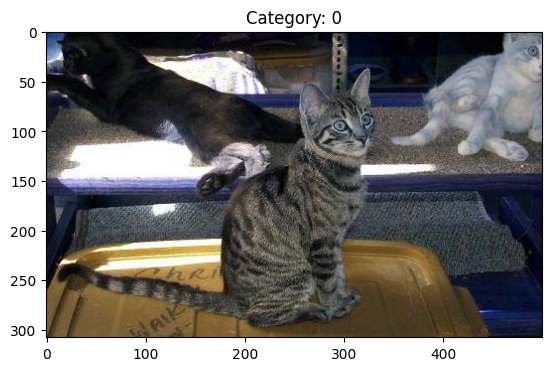

In [4]:

index = np.random.choice(df.index)
filename = df.loc[index, 'filename']
category = df.loc[index, 'category']
img = cv2.imread('kaggle/dogs-vs-cats-redux-kernels-edition/train/' + filename)
plt.imshow(img)
plt.title(f'Category: {category}')
plt.show()
# test

In [5]:
df

,filename,category
0,cat.5663.jpg,0
1,dog.11277.jpg,1
2,cat.1240.jpg,0
3,dog.5978.jpg,1
4,cat.365.jpg,0
...,...,...
24995,dog.11600.jpg,1
24996,cat.9071.jpg,0
24997,dog.8132.jpg,1
24998,cat.5560.jpg,0


In [6]:


train_df,validate_df = train_test_split(df,train_size = 0.7, random_state = 42)
batch_size = 64

img_size = (128,128)
channels = 3
img_shape = (img_size[0],img_size[1],channels)

In [7]:


# Create different ImageDataGenerator objects for training and testing/validation sets
tr_gen = ImageDataGenerator(rescale=1./255, 
                               shear_range=0.15, 
                               zoom_range=0.2, 
                               horizontal_flip=True)
ts_gen = ImageDataGenerator(rescale=1./255 )

In [16]:

# Specify the directory argument for each set
train_gen = tr_gen.flow_from_dataframe(dataframe = train_df, directory = 'kaggle/dogs-vs-cats-redux-kernels-edition/train',x_col = 'filename' ,y_col = 'category', target_size = img_size, class_mode = 'binary',color_mode = 'rgb'
                                      , shuffle = True, batch_size = batch_size)
validate_gen = ts_gen.flow_from_dataframe(dataframe = validate_df, directory = 'kaggle/dogs-vs-cats-redux-kernels-edition/train', x_col = 'filename' ,y_col = 'category', target_size = img_size, class_mode = 'binary',color_mode = 'rgb'
                                      , shuffle = True, batch_size = batch_size)

Found 17500 validated image filenames belonging to 2 classes.
Found 7500 validated image filenames belonging to 2 classes.


In [17]:

# Model
base_model = tf.keras.applications.EfficientNetB4(
    include_top=False,
    input_shape = img_shape,
    weights="imagenet",
    pooling='max',
)
model = Sequential([
    base_model,
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(Adam(learning_rate = 0.0001), loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 1792)              17673823  
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 1024)              1836032   
                                                                 
 batch_normalization_10 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_11 (Ba  (None, 512)              

In [18]:

early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
history = model.fit(x= train_gen, epochs = 50 ,verbose = 1,validation_data = validate_gen, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


2024-02-01 12:54:36.545000: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


274/274 [==============================] - ETA: 0s - loss: 0.6230 - accuracy: 0.7258

/home/xpert/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 69s 159ms/step - loss: 0.6230 - accuracy: 0.7258 - val_loss: 0.8873 - val_accuracy: 0.5151
Epoch 2/50
274/274 [==============================] - 42s 154ms/step - loss: 0.3650 - accuracy: 0.8540 - val_loss: 1.2483 - val_accuracy: 0.5935
Epoch 3/50
274/274 [==============================] - 41s 151ms/step - loss: 0.2558 - accuracy: 0.8963 - val_loss: 0.3641 - val_accuracy: 0.8400
Epoch 4/50
274/274 [==============================] - 45s 163ms/step - loss: 0.2056 - accuracy: 0.9185 - val_loss: 0.3411 - val_accuracy: 0.8643
Epoch 5/50
274/274 [==============================] - 43s 155ms/step - loss: 0.1631 - accuracy: 0.9333 - val_loss: 0.8992 - val_accuracy: 0.6037
Epoch 6/50
274/274 [==============================] - 44s 159ms/step - loss: 0.1410 - accuracy: 0.9439 - val_loss: 0.3356 - val_accuracy: 0.8664
Epoch 7/50
274/274 [==============================] - 42s 151ms/step - loss: 0.1218 - accuracy: 0.9502 - val_loss: 0.3079 - val_accuracy: 0.8

In [19]:

test_filenames = os.listdir('kaggle/dogs-vs-cats-redux-kernels-edition/test')
test_df = pd.DataFrame({
    'filename': test_filenames
})

test_generator = ts_gen.flow_from_dataframe(
    test_df,
    'kaggle/dogs-vs-cats-redux-kernels-edition/test', 
    x_col='filename',
    y_col=None,
    target_size=(128, 128),
    class_mode=None,
    batch_size=64,
    shuffle=False
)

Found 12500 validated image filenames.


In [20]:

# Load the best model and predict the test data
best_model = tf.keras.models.load_model('best_model.h5')
predict = best_model.predict(test_generator)
print(predict.shape)

196/196 [==============================] - 8s 34ms/step
(12500, 1)


In [19]:
predicted_classes = np.argmax(predict, axis=1)
print(predicted_classes)
predicted_classes.shape

[0 0 1 ... 1 1 1]


(12500,)

In [23]:
test_df['id'] = test_df['filename'].str.split('.').str[0]
test_df['label'] = predict

In [24]:
test_df.drop(columns=['filename'], inplace=True)
test_df.to_csv('submission.csv', index=False)

In [27]:
# draw confusion matrix

# get the true labels
y_true = validate_gen.classes

# get the predicted labels
y_pred = best_model.predict(validate_gen)
y_pred = y_pred > 0.5
y_pred = y_pred.astype(int)

# get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

118/118 [==============================] - 4s 35ms/step


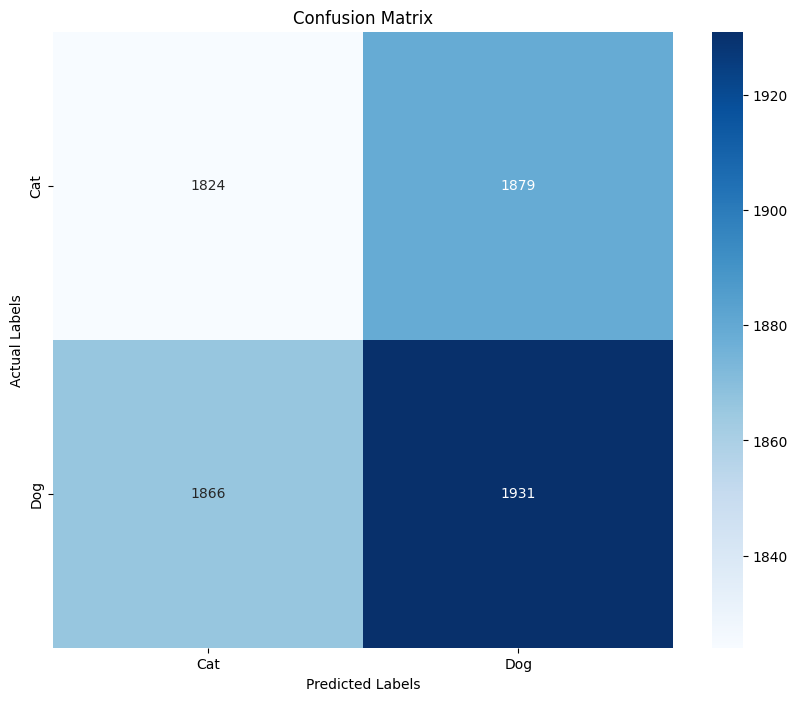

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.savefig('confusion_matrix.png')
plt.show()